You got a lot of time series and want to predict the next step (or steps). What should you do now? Train a model for each series? Is there a way to fit a model for all the series together? Which is better?

I have seen many data scientists think about approaching this problem by creating a single model for each product. Although this is one of the possible solutions, it's not likely to be the best. 

Here I will demonstrate how to train a single model to predict multiple time series at the same time. This technique usually creates powerful models that help teams win machine learning competitions and can be used in your project.

<h1>Individual Models vs Big Model for Everything</h1>

In machine learning, more data usually means better predictions. If you try to create one model for each series, you will have some trouble with series that have little to no data. When you concatenate all your series into a single dataset, to train a single model, you are using a lot more data. This may help the model perform better!

Considering more than one series at a time, the model will be able to learn more subtle patterns that repeat across series. The product becomes a variable in our model.

First, let's import our basic tools:

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

<h1>Preparing the Data</h1>

The data was obtained from the [UCI Repository](https://archive.ics.uci.edu/ml/datasets/Sales_Transactions_Dataset_Weekly). 

Here we will try to forecast sales for 811 products. Our dataset has records of sales for 52 weeks for each of the products.

This means we have, originally, 811 time series with 52 data points each. Here I take only the Product Code and non-normalized weekly sales for each product.

This is what the data looks like:

In [ ]:
data = pd.read_csv('Sales_Transactions_Dataset_Weekly.csv')
data = data.filter(regex=r'Product|W')
data.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,...,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,...,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,...,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,...,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,...,7,11,7,12,6,6,5,11,8,9


At this point, many data scientists would try to fit a model for each product. And while this can work well, we may have problems due to having only 52 data points for each model, which is really low!

As machine learning models tend to improve with more data, why not try to concatenate all the series and train a single model with much more data?

To do this we have to "melt" the data. This simply means transforming the data in a way that each line becomes: **Product Code, Week, Sales**

To make our lives easier, I decided to remove the letters from the product and week code.

In [ ]:
melt = data.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')

melt['Product_Code'] = melt['Product_Code'].str.extract('(\d+)', expand=False).astype(int)
melt['Week'] = melt['Week'].str.extract('(\d+)', expand=False).astype(int)

melt = melt.sort_values(['Week', 'Product_Code'])
melt.head()

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8


Now we have **42172 rows** to train our model.

# Basic Feature Engineering

We need to have variables to send to our model and get the predictions. For now, besides the product code and the week, I will create two features that usually help a lot with time series: lags and differences.

**Last Week Sales**: this is simply the amount of sales that a product had in the previous week  
**Last Week Diff**: the difference between the amount of sales in the previous week and the week before it (t-1 - t-2)

In [ ]:
melt2 = melt.copy()
melt2['Last_Week_Sales'] = melt2.groupby(['Product_Code'])['Sales'].shift()
melt2['Last_Week_Diff'] = melt2.groupby(['Product_Code'])['Last_Week_Sales'].diff()
melt2 = melt2.dropna()
melt2.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
1622,1,2,10,12.0,1.0
1623,2,2,3,6.0,-1.0
1624,3,2,8,11.0,4.0
1625,4,2,13,8.0,-4.0
1626,5,2,13,5.0,-3.0


# Evaluating the Result

To know if our model is good we need to have an evaluation metric. A metric I really like for sales forecasting is the Root Mean Squared Log Error.

This is our well-known RMSE applied to the log of the target and the prediction output.

It works as an approximation to the percentage error between our predictions and the target, which is a nice way to understand the errors our model is making.

In [ ]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

# Setting a Baseline and a Validation Split

Let's say that in real life your model will run every Sunday night, so that early on Monday the managers can make decisions based on the predictions for the next week.

To see if our model will work in this scenario, weeks it has not seen before, I will use a sliding window validation. This means that we are going to simulate training the model in all the weeks up to the one we want to predict, and evaluate our score in the new week.

And, to avoid having a very good model in a small amount of weeks simply due to luck, I will use every week from 40 to 52, repeating the process for one at a time, and compute the score.

As this is only a demonstration of the method, to keep it simple I am not separating a test set. In your projects, always keep some periods out of your validation to evaluate your model when you finish developing it. **This is very important**, and helps you be more secure about your model performing well when deployed.

To make sure the model is worth using I like to set a baseline score that it has to beat. In this case, a reasonably strong baseline is using the last week amount of sales as a prediction for the sales this week.

In [ ]:
mean_error = []
for week in range(40,52):
    train = melt2[melt2['Week'] < week]
    val = melt2[melt2['Week'] == week]
    
    p = val['Last_Week_Sales'].values
    
    error = rmsle(val['Sales'].values, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.51952
Week 41 - Error 0.51691
Week 42 - Error 0.51026
Week 43 - Error 0.50792
Week 44 - Error 0.53409
Week 45 - Error 0.52347
Week 46 - Error 0.50018
Week 47 - Error 0.49138
Week 48 - Error 0.50585
Week 49 - Error 0.50547
Week 50 - Error 0.52220
Week 51 - Error 0.55242
Mean Error = 0.51581


Now we know that our model has to have a better error than about 0.51. This would be approximately 50% error in each prediction, which seems huge! But is it really?

If we look at the distribution of sales in the dataset, we see that a lot of items sell very little amounts. So we should expect the error to look "high".

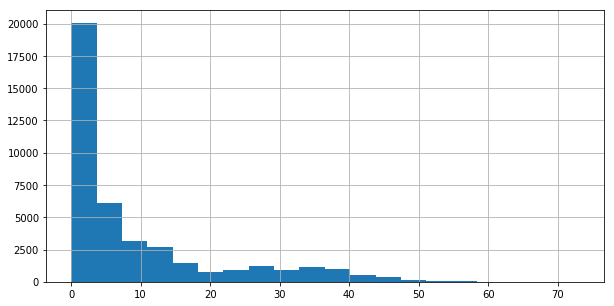

In [ ]:
melt2['Sales'].hist(bins=20, figsize=(10,5))

# Creating the Model

Now that we have a baseline, let's try to beat it!

As a first model, let's train a Random Forest. Besides being a strong model with structured data (like the one we have), we usually can already get a very good result by just setting a high number of trees.

I usually tell data scientists that a Random Forest is a very good model to use in a lazy day. You only set the number of trees to the maximum your computer can run and get a good model (hopefully).

I will keep the Week as a feature although our model will have never seen the new week value. It may be that after week 35, for example, we have more sales for a product. This type of effect can be captured by the model.

As decision trees can handle categorical features well even in ordinal encoding, I left them in this format.

Anyway, be careful with these types of features.

In [ ]:
mean_error = []
for week in range(40,52):
    train = melt2[melt2['Week'] < week]
    val = melt2[melt2['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.46242
Week 41 - Error 0.45964
Week 42 - Error 0.46166
Week 43 - Error 0.46655
Week 44 - Error 0.47122
Week 45 - Error 0.43100
Week 46 - Error 0.47183
Week 47 - Error 0.44945
Week 48 - Error 0.46080
Week 49 - Error 0.44696
Week 50 - Error 0.47465
Week 51 - Error 0.48651
Mean Error = 0.46189


Nice!

Applying the Random Forest to our initial variables we got a good reduction of the error (about 10%). This is a very good way to start.

Now, let's try to add some features from more weeks in the past. First, let's add the lag and the difference of sales for the week before the previous.

In [ ]:
melt3 = melt.copy()
melt3['Last_Week_Sales'] = melt3.groupby(['Product_Code'])['Sales'].shift()
melt3['Last_Week_Diff'] = melt3.groupby(['Product_Code'])['Last_Week_Sales'].diff()
melt3['Last-1_Week_Sales'] = melt3.groupby(['Product_Code'])['Sales'].shift(2)
melt3['Last-1_Week_Diff'] = melt3.groupby(['Product_Code'])['Last-1_Week_Sales'].diff()
melt3 = melt3.dropna()
melt3.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff
2433,1,3,8,10.0,-2.0,12.0,1.0
2434,2,3,2,3.0,-3.0,6.0,-1.0
2435,3,3,9,8.0,-3.0,11.0,4.0
2436,4,3,5,13.0,5.0,8.0,-4.0
2437,5,3,11,13.0,8.0,5.0,-3.0


Again, we train a model, now using the old variables plus the two new.

In [ ]:

mean_error = []
for week in range(40,52):
    train = melt3[melt3['Week'] < week]
    val = melt3[melt3['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.44389
Week 41 - Error 0.45812
Week 42 - Error 0.43652
Week 43 - Error 0.44033
Week 44 - Error 0.46318
Week 45 - Error 0.42361
Week 46 - Error 0.45752
Week 47 - Error 0.44533
Week 48 - Error 0.44598
Week 49 - Error 0.43538
Week 50 - Error 0.47349
Week 51 - Error 0.46487
Mean Error = 0.44902


Great! Another reduction!

Can you guess my next idea?

Let's try a model with one more lag and difference, of course!

In [ ]:
melt4 = melt.copy()
melt4['Last_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift()
melt4['Last_Week_Diff'] = melt4.groupby(['Product_Code'])['Last_Week_Sales'].diff()
melt4['Last-1_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift(2)
melt4['Last-1_Week_Diff'] = melt4.groupby(['Product_Code'])['Last-1_Week_Sales'].diff()
melt4['Last-2_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift(3)
melt4['Last-2_Week_Diff'] = melt4.groupby(['Product_Code'])['Last-2_Week_Sales'].diff()
melt4 = melt4.dropna()
melt4.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff,Last-2_Week_Sales,Last-2_Week_Diff
3244,1,4,13,8.0,-2.0,10.0,-2.0,12.0,1.0
3245,2,4,7,2.0,-1.0,3.0,-3.0,6.0,-1.0
3246,3,4,10,9.0,1.0,8.0,-3.0,11.0,4.0
3247,4,4,9,5.0,-8.0,13.0,5.0,8.0,-4.0
3248,5,4,6,11.0,-2.0,13.0,8.0,5.0,-3.0


In [ ]:
mean_error = []
for week in range(40,52):
    train = melt4[melt4['Week'] < week]
    val = melt4[melt4['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.43096
Week 41 - Error 0.43894
Week 42 - Error 0.42754
Week 43 - Error 0.41965
Week 44 - Error 0.44807
Week 45 - Error 0.40729
Week 46 - Error 0.43950
Week 47 - Error 0.43334
Week 48 - Error 0.43856
Week 49 - Error 0.43049
Week 50 - Error 0.45920
Week 51 - Error 0.45356
Mean Error = 0.43559


As expected, the error is reduced.

I will stop the lag and difference creation here, as I am getting repetitive with this, but feel free to try more lags, differences, and even other features to see when they stop improving.

# Changing the Loss Function (and Target Distribution)

We are evaluating our results using the log of our predictions and target, but we are training using them in their original form, so we are optimizing the model using the MSE instead of the MSLE. 

Usually you get an improvement by using the same function to evaluate and optimize your model. In this case we can do this by simply taking the log of our target variable before passing it to the fit model. 

Sometimes it's not possible to optimize the evaluation function directly. In this case, look for an approximation. We can say we are already using an approximation here (of the percentage error).

By taking the log of the target we get the added bonus that its distribution will look closer to a normal distribution. This usually helps the model learn better.

In [ ]:

mean_error = []
for week in range(40,52):
    train = melt4[melt4['Week'] < week]
    val = melt4[melt4['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.41679
Week 41 - Error 0.42251
Week 42 - Error 0.41238
Week 43 - Error 0.40354
Week 44 - Error 0.43317
Week 45 - Error 0.39745
Week 46 - Error 0.42623
Week 47 - Error 0.41229
Week 48 - Error 0.43018
Week 49 - Error 0.43758
Week 50 - Error 0.44610
Week 51 - Error 0.47289
Mean Error = 0.42593


Yes! Lower error!

# A Better Model

Anyone that ever stumbled over a machine learning competition solution may know about the love of competitors for Gradient Boosted Trees. I am guilty of this too!

It's very common to have the best results with this type of model, which is an ensemble of trees like a Random Forest, but the method that it uses to create and combine the trees is different. Worth understanding.

This is a very good scenario for us to try this model and see if we can reduce the error even more!

There are many parameters we can tune for this model, but I will simply put 1000 trees with a small learning rate. If you want to improve the prediction, you can try tuning it and leave a comment about the improvement you got.

In [ ]:
mean_error = []
for week in range(40,52):
    train = melt4[melt4['Week'] < week]
    val = melt4[melt4['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.40960
Week 41 - Error 0.39913
Week 42 - Error 0.39525
Week 43 - Error 0.39711
Week 44 - Error 0.42211
Week 45 - Error 0.37741
Week 46 - Error 0.40374
Week 47 - Error 0.39017
Week 48 - Error 0.39724
Week 49 - Error 0.40813
Week 50 - Error 0.42336
Week 51 - Error 0.45235
Mean Error = 0.40630


Very good! 

This model gave us a sizeable improvement, we are almost below the 0.40 barrier. Let's take a look at our predictions for Week 52.

/Users/mnestevao/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


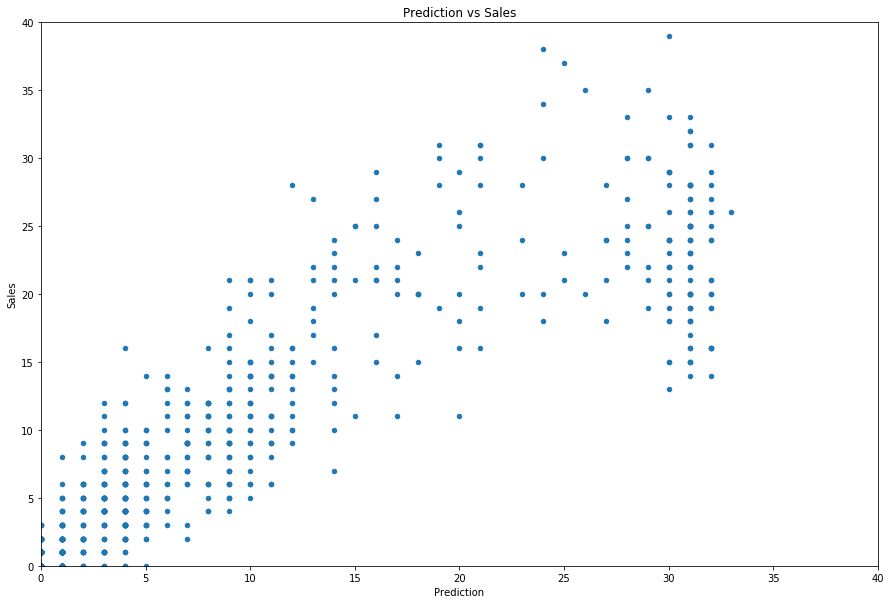

In [ ]:
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='Sales', figsize=(15,10), title='Prediction vs Sales', 
                 ylim=(0,40), xlim=(0,40))

Our model is doing reasonably well for items that have sales under about 25 units. 

But we can see a "cluster" of products that have about 30 sales a day where our model underpredicts. We should definitely investigate this group, understand why this is happening, and see if we can fix it.

Are we missing information? Maybe these are products bought in bulk? Or the units are different (pounds vs ounces)?

Now, to get predictions for each time serie, your just need put the product code, week and compute the new features.

Remember our baseline at RMSLE 0.51581? We improved it to 0.4063, which means a **21% error reduction!**

# Improving the Solution

Some ideas you can try to improve this solution:

- Investigate products with sales over 25 units.
- Try more features (lags, differences) not only at the product level, but at the global.
- Try using LightGBM native support for categorical features with Product Code.
- Try tuning the model hyperparameters.
- Try a neural network and ensemble with GBM.

Remember to let us know how your experiments went by leaving a comment!